<img src="https://gitlab.inf.unibz.it/earth_observation_public/eurac-openeo-examples/-/raw/main/python/aux_data/eurac_EO.png"
     alt="EURAC EO logo"
     style="float: left; margin-right: 10px; max-width: 300px" />

# Land Cover Classification - Part 1

Author michele.claus@eurac.edu

Date: 2023/09/14

During this exercise we will perform a land cover classification task using open source software and data.

We will start with a simple version to a more advanced one, where we will consider more aspects. 

## 1. Training Dataset Generation

In this exercise, we will focus on 4 main classes:
1. artificial surfaces
2. agricultural areas
3. forests and seminatual areas
4. water bodies

The names of these classes comes from Corine Land Cover Level 0 classification scheme: https://wiki.openstreetmap.org/wiki/Corine_Land_Cover

### 1.1 Sample points selection

Generate 4 geoJSON files containing at least 10 points for each class using the website: https://geojson.io/#map=12/46.48882/11.33004

For simplicity, we will work within the area of Bolzano, where Eurac Research is located.

Follow this procedure for each land cover class:
1. Open the link: https://geojson.io/#map=12/46.48882/11.33004
2. Switch to satellite view selecting "Satellite Streets" as a base layer in the bottom left corner
3. Select the point tool and place a point in an area corresponding to the class
4. Repeat until you have at least 10 points
5. Save the geoJSON file with the top-left toolbar
6. Repeat for the other classes

### 1.2 Read the sample points in Python

Modify the file paths to match the files that you generated

In [1]:
urban_points_file = "./geojson/urban.geojson"
crops_points_file = "./geojson/crop.geojson"
forest_points_file = "./geojson/forest.geojson"
water_points_file = "./geojson/water.geojson"

Use GeoPandas to read the vector data. We also assign the corresponding Corine Land Cover code.

In [2]:
import geopandas as gpd
import numpy as np

df_urban = gpd.read_file(urban_points_file).assign(**{"label":100})
df_crops = gpd.read_file(crops_points_file).assign(**{"label":200})
df_forest = gpd.read_file(forest_points_file).assign(**{"label":300})
df_water = gpd.read_file(water_points_file).assign(**{"label":500})

Inspect a GeoDataFrame object containing the sample points

In [3]:
df_urban.head(3)

,geometry,label
0,POINT (11.32883 46.48775),100
1,POINT (11.34056 46.49088),100
2,POINT (11.33035 46.49110),100


We would like to extract the bounds of the area containing our sample points.

To do that we can combine the different GeoDataFrames into a single one and sue the `total_bounds` method.

In [4]:
import pandas as pd
sample_points = pd.concat([df_urban,df_crops,df_forest,df_water])
bbox = sample_points.total_bounds
bbox

array([11.29689773, 46.45952576, 11.37833251, 46.50871696])

### 1.3 Satellite data retrieval

We will use optical Sentinel-2 data from the months of June, July and August 2022.

The data is provided by a public STAC Catalog, where Sentinel-2 L2A data is made available for free.

We will use the openEO Python Client with its [Client Side Processing functionality](https://open-eo.github.io/openeo-python-client/cookbook/localprocessing.html) to download the required data.

Please make sure to have the latest version of openeo, openeo-pg-parser-networkx and openeo-processes-dask.

If you are not sure about the current version, you can uncomment the next cell and run it.

In [5]:
#pip install openeo[localprocessing] openeo-pg-parser-networkx openeo-processes-dask[implementations,ml] --upgrade

In [6]:
from openeo.local import LocalConnection
local_conn = LocalConnection("./")

url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a"
spatial_extent =  {"west": bbox[0], "south": bbox[1], "east": bbox[2], "north": bbox[3]}
temporal_extent = ["2022-06-01", "2022-08-31"]
bands = ["B04","B03","B02","B08"] # B04 = red, B03 = green, B02 = blue, B08 = near infrared
properties = {"eo:cloud_cover": dict(lt=30)}

datacube = local_conn.load_stac(
    url=url,
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=bands,
    properties=properties,
)

datacube_xr = datacube.execute()
datacube_xr

C:\Users\mclaus\Miniconda3\envs\stacenv\lib\site-packages\openeo\metadata.py:264: UserWarning: No cube:dimensions metadata
  complain("No cube:dimensions metadata")


<xarray.DataArray 'stackstac-8e0dd98d9777c7b15c60f3f0c662c08f' (time: 18,
                                                                band: 4,
                                                                y: 566, x: 641)>
dask.array<getitem, shape=(18, 4, 566, 641), dtype=float64, chunksize=(1, 1, 450, 570), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2022-06-10...
    id                                       (time) <U54 'S2A_MSIL2A_20220610...
  * band                                     (band) <U3 'B04' 'B03' 'B02' 'B08'
  * x                                        (x) float64 6.762e+05 ... 6.826e+05
  * y                                        (y) float64 5.153e+06 ... 5.148e+06
    platform                                 (time) <U11 'Sentinel-2A' ... 'S...
    ...                                       ...
    title                                    (band) <U20 'Band 4 - Red - 10m'...
    gsd                                      float64 10.0
    common_name                              (band) <U5 'red' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.665 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.038 ... 0.145
    epsg                                     int32 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 5090220.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5200020.00|\n| 0.0...
    resolution:  10.0

Visualize a sample image of the selected ones:

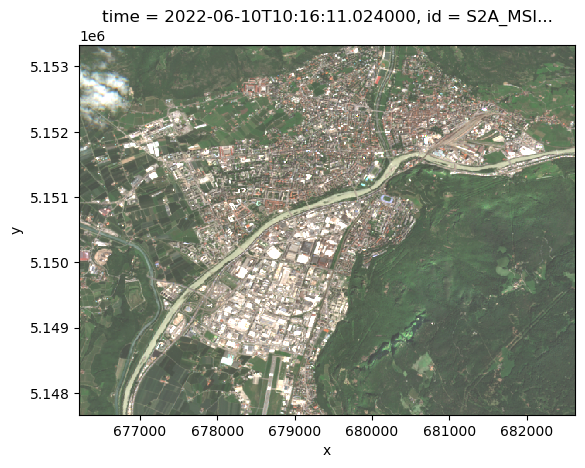

In [7]:
(datacube_xr[0,:3].clip(0,3500)/3500).plot.imshow()

Perform a temporal aggregation to get a monthly median of the data and visualize the correspnding openEO process graph:

In [8]:
import numpy as np
resampled_data = datacube_xr.resample({"time": "M"})
aggregated_xr = resampled_data.reduce(np.median)
aggregated_xr

<xarray.DataArray 'stackstac-8e0dd98d9777c7b15c60f3f0c662c08f' (time: 3,
                                                                band: 4,
                                                                y: 566, x: 641)>
dask.array<stack, shape=(3, 4, 566, 641), dtype=float64, chunksize=(1, 4, 566, 641), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * band                                     (band) <U3 'B04' 'B03' 'B02' 'B08'
  * x                                        (x) float64 6.762e+05 ... 6.826e+05
  * y                                        (y) float64 5.153e+06 ... 5.148e+06
    s2:processing_baseline                   <U5 '04.00'
    s2:mgrs_tile                             <U5 '32TPS'
    sat:orbit_state                          <U10 'descending'
    ...                                       ...
    gsd                                      float64 10.0
    common_name                              (band) <U5 'red' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.665 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.038 ... 0.145
    epsg                                     int32 32632
  * time                                     (time) datetime64[ns] 2022-06-30...
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 5090220.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5200020.00|\n| 0.0...
    resolution:  10.0

In [9]:
aggregated = datacube.aggregate_temporal_period(period="month",reducer="median")
aggregated

The xArray object currently contains the metadata only.
    
Only when calling `.compute()`, the data will be downloaded and stored in memory.

In [10]:
%%time
aggregated_xr = aggregated.execute()
aggregated_xr = aggregated_xr.compute()

CPU times: total: 27.6 s
Wall time: 1min 29s


Save the data as a netCDF file:

In [11]:
%%time
# Remove problematic attributes and coordinates, which prevent to write a valid netCDF file
for at in aggregated_xr.attrs:
    # allowed types: str, Number, ndarray, number, list, tuple
    if not isinstance(aggregated_xr.attrs[at], (int, float, str, np.ndarray, list, tuple)):
        aggregated_xr.attrs[at] = str(aggregated_xr.attrs[at])

for c in aggregated_xr.coords:
    if aggregated_xr[c].dtype=="object":
        aggregated_xr = aggregated_xr.drop_vars(c)

aggregated_xr.to_dataset(dim="band").to_netcdf("sentinel_2_2022.nc")

CPU times: total: 62.5 ms
Wall time: 63.8 ms


You can reload the stored netCDF in this way:

In [12]:
import xarray as xr

data = xr.open_dataset("sentinel_2_2022.nc",chunks={}).to_array(dim="band").chunk(dict(band=-1,x=256,y=256))

### 1.3 Predictors/Features extraction

Given the selected sample points and the retired satellite data, we can now extract the data values corresponing to each sample point.

Each data array extracted will be called `predictor` or `feature` vector.

#### 1.3.1 Points - Data projection alignment

The geoJSON files contain points with coordinates expressed in lat/lon (WGS84 / EPSG:4326 coordinate system).

However, the data doesn't necessarily has the same projection.
Therefore, we reproject points to match data projection.

In [13]:
sample_points_reproj = sample_points.to_crs(data.crs)

#### 1.3.2 Feature Vector extraction

Given the reprojected points we can get the corresponding values and create feature vectors, which will be used for training.

We store the feature vectores in the same GeoDataFrame as the sampled points:

In [14]:
predictors = []
for idx,s in enumerate(sample_points_reproj.iterrows()):
    point = s[1]["geometry"]
    data_values = data.sel(x=point.x,y=point.y,method='nearest').values
    feature_vector = np.ndarray.flatten(data_values)
    predictors.append(feature_vector)
sample_points_reproj = sample_points_reproj.assign(**{"features":predictors})
sample_points_reproj

,geometry,label,features
0,POINT (678733.219 5150876.795),100,"[2302.0, 2514.0, 2336.0, 1746.0, 1968.5, 1868...."
1,POINT (679623.239 5151251.375),100,"[2074.0, 2144.0, 1946.0, 1796.0, 1815.0, 1776...."
2,POINT (678838.582 5151252.833),100,"[2490.0, 2372.0, 2322.0, 1986.0, 2045.5, 2018...."
3,POINT (679075.269 5150069.496),100,"[5332.0, 5188.0, 5156.0, 5368.0, 5172.0, 5092...."
4,POINT (678776.558 5149460.191),100,"[2730.0, 2607.0, 2280.0, 2486.0, 2453.0, 2076...."
5,POINT (679886.342 5150460.642),100,"[2442.0, 2519.0, 2292.0, 2210.0, 2178.0, 2156...."
6,POINT (678047.754 5150715.131),100,"[1978.0, 1966.0, 1732.0, 1871.0, 1864.0, 1662...."
7,POINT (678261.919 5149167.079),100,"[2270.0, 2189.0, 2046.0, 2066.0, 2128.0, 1921...."
8,POINT (680532.627 5152198.803),100,"[2050.0, 2060.0, 1899.0, 1741.0, 1732.5, 1601...."
9,POINT (681050.795 5152361.760),100,"[2266.0, 2305.0, 2260.0, 2246.0, 2133.0, 2078...."


We perform some operations to:
1. Get the feature vector in the desired shape: NxM with N as the number of points and M the number of features (in this case bands*time)
2. Get the corresponding label vector with the correct format. The ML library we are using is expecting labels with values starting from 0 and therefore we have to map them.

In [15]:
dict_mapping = {}
[dict_mapping.update({x:l}) for x,l in enumerate(np.unique(sample_points_reproj["label"].values))]
dict_mapping

{0: 100, 1: 200, 2: 300, 3: 500}

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(sample_points_reproj["label"].values)

In [17]:
x_train = np.asarray([x for x in sample_points_reproj["features"].values])

## 2 Random Forest

We use the xgboost ML library with its Random Forest implementation.

For more info please read the documentation here:

https://xgboost.readthedocs.io/en/stable/tutorials/rf.html#standalone-random-forest-with-scikit-learn-like-api

and for the colsample_by* hyperparameters explanation check this nice article here:

https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1

### 2.1 Model training

In [18]:
from xgboost import XGBRFClassifier
model = XGBRFClassifier(n_estimators=100, subsample=0.9)
model.fit(x_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='multi:softprob', predictor=None, random_state=None,
                reg_alpha=None, ...)

### 2.2 Model prediction

To speed up the prediction process, we parallelize using xarray `apply_ufunc`, which allows to apply the same function call to multiple data chunks in parallel using Dask.

In [19]:
import xarray as xr

def predict_rf(x):
    d = np.reshape(x,(x.shape[0]*x.shape[1],x.shape[2]*x.shape[3]))
    pred = model.predict(d)
    return np.reshape(pred,(x.shape[0],x.shape[1]))
    
def predict(obj, dims):
    return xr.apply_ufunc(
        predict_rf, obj, input_core_dims=[dims], dask = "parallelized", output_dtypes = [int]
    )

predicted = predict(data,["band","time"]).compute()

## 3. Prediction Evaluation

Now that our model has been trained and the prediction generated based on it, we can evaluate the result.

We didn't do any split of the training set due to the limited number of samples, so we don't have any test or validation set to use.

For this simple example, please evaluate the result using QGIS (or equivalent GIS software) and a satellite layer as a reference.

In the next notebook we will also perform the evaluation in a programmatic manner.

In [20]:
# Store the result in a geotiff
predicted = predicted.rio.write_crs(data.crs)
predicted.rio.to_raster("predicted.tif")

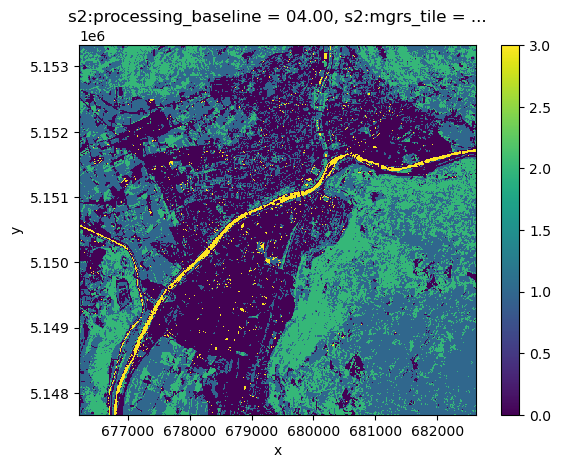

In [21]:
# Visualize the result
predicted.plot.imshow()